# Project Litmus (pH)

This workbook provides the template for the final project. 

## Instructions
- Work individually or in pairs
- Each team is to complete 1 copy of this template.
  - Complete all sections.
  - Feel free to include supporting material / slides / documents as needed.
- At the end of the project, you will get 15 minutes to present this workbook to the class.

### Submission Instructions
- Submit the .ipynb with the Output cells showing the results
  - Naming convention:
  ```
      <name1>-<name2>-<project_short_name>.ipynb
  ```
- If you provide your own datasets, include the data with your .ipynb

In [ ]:
grade = {'Project Goals and Plan (5)': 5,
     'Data Preparation and Feature Selection (10)': 10,
     'Training and Evaluation (20)': 20, # Good use of PCA feature reduction techniques
     'Observations and Analysis (10)': 9, # this is a project that will benefit from
                                          # a lot more data, as you seem to be underfitting
                                          # the classifier. Good effort!
     'Presentation (5)': 5} # Good use of slides to provide the background for this project

total_grade = sum(grade.values())
print(total_grade)

if total_grade > 30:
    print('Passed, Good job!')

## Section 0: Team Members
- Edwin
- Shabeena

## Section 1: Project Litmus (pH)

- Prediciting the scanned image quality

## Section 2: Project Definition

### Goals

Describe the goal of this project.

1. To train a classifer which is able to identify which class a scanned image is. Background defect, General defect and Good image

Important:
- If this is your first project, keep the project definition as simple as possible. 
- As a rule of thumb, pick something that can be completed in 2-3 days. There is always more you can add to it if you finish early. 
- If you are not sure, use the workshop problems as a reference.

### Dataset

Briefly describe the source(s) of data you are using.
Data collected from the manual scan of the images

#### Format: jpg

#### Columns:
 
|Name|Type|Unit of Measure|Description|
|--|--|--|--|
|month|Datetime, YYYY-MM|none|date range: Jan 1, 2010 to Mar 31, 2018|
|bidding_no|Numeric|No. of Bids|Number of Bids|
|vehicle_class|Text|none|Vehicle category: A to E|
|quota|Numeric|No. of Bids|Number of Quota|
|bids_success|Numeric|No. of Bids|Number of Successful Bids|
|bids_received|Numeric|No. of Bids|Number of Bids Received|
|premium|Numeric|S$|COE premium|

### Tasks

List the tasks you will perform. 

Example:
 
1. Process the dataset to convert strings into labels.
2. Shuffle and split into train and test sets
3. Train a clustering algorithm, using Gaussian Mixture Model with 5 components, where each component is a vehicle category.
4. Compute the metrics for the algorithm.
5. Perform analysis for possible improvements.

## Section 3: Prepare Dataset

Write your code below to prepare the dataset using pandas

In [1]:
# Update to set the path of your dataset
# You can use an absolute path (e.g. 'D:/tmp/data') or a relative path
dataset_path='C:/courses/mldds-courseware/Projects/Litmas pH project/Cleaned up'

# Data Augmentation

In [2]:
# https://keras.io/preprocessing/image/#imagedatagenerator-class
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# 160x160 matches one of the sizes supported by MobileNet
# (the neural network we'll transfer learn from)
img_height = img_width = 160
channels = 3


#no rescale
datagen = ImageDataGenerator(rotation_range=45,
                            zoom_range=.2,
                            preprocessing_function=preprocess_input)

# generate image data from the training set
generator = datagen.flow_from_directory(dataset_path,
                                        color_mode='rgb',
                                        target_size=(img_height, img_width),
                                        batch_size=200,
                                        class_mode='categorical',
                                        shuffle=True)

X_dataset, y_dataset = next(generator) # gets 1 batch of 45 images

# display some images
#y[0] -->nbr
x, y = next(generator)
plt.imshow(x[0])
plt.title(y[0])
plt.show()

x, y = next(generator)
plt.imshow(x[0])
plt.title(y[0])
plt.show()

Using TensorFlow backend.


Found 205 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 1 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 1 Axes>

In [3]:
X_dataset.shape

(200, 160, 160, 3)

## Section 4: Select Features

Write your code below to create X_train, X_test, y_train, y_test

In [4]:
#Split datasets into train, test, validate

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
 
(X_train, X_test, Y_train, Y_test) = train_test_split(X_dataset, y_dataset , random_state=42)

print(X_train.shape)

(150, 160, 160, 3)


## Section 5: Train the algorithm(s)

Write your code below to initialize and train the algorithm(s)

# Convoluted Network (MobileNet) v.s. SVM

# Section A (MobileNet)

In [5]:
from keras.applications import MobileNet

image_height = image_width = 160 # pixels (alternatively 224)
channels = 3 # RGB

featurizer = MobileNet(input_shape=(image_height, image_width, channels),
                       include_top=False) # drop the classifier part
featurizer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 162, 162, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 82, 82, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
__________

In [6]:
X_train_features = featurizer.predict(X_train)
print(X_train_features.shape)

(150, 5, 5, 1024)


In [7]:
# 2. fit classifier using features and labels (y_train)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

classifier = Sequential()
classifier.add(Flatten(input_shape=X_train_features.shape[1:])) # 5,5,1024 -> 5*5*1024

classifier.add(Dense(64, activation='relu')) # first fully-connected layer

classifier.add(Dropout(0.5)) # to prevent overfitting, randomly drop some nodes

# 3 classes! softmax: 0-1, multi-class, probability
# 2 classes? sigmoid
# 195 = 64 (input) * 3 (output) + 3 (bias)
classifier.add(Dense(3, activation='softmax')) # second fully-connected layer

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1638464   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,638,659
Trainable params: 1,638,659
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import time

# Keras training
# compile
classifier.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# setup callbacks (optional): tensorboard, early stopping, model checkpoint
tensorboard = TensorBoard(log_dir='logs/classifier/%d' % time.time())
earlystop = EarlyStopping(patience=2)

# fit
classifier.fit(X_train_features, Y_train, epochs=50,
               callbacks=[tensorboard, earlystop],
               validation_split=0.1)

Train on 135 samples, validate on 15 samples
Epoch 1/50
135/135 [==============================] - 1s 7ms/step - loss: 4.4689 - acc: 0.4444 - val_loss: 4.8645 - val_acc: 0.4667
Epoch 2/50
135/135 [==============================] - 0s 1ms/step - loss: 6.0378 - acc: 0.4889 - val_loss: 6.9721 - val_acc: 0.4667
Epoch 3/50
135/135 [==============================] - 0s 1ms/step - loss: 5.1534 - acc: 0.6148 - val_loss: 5.7769 - val_acc: 0.4667


In [9]:
# save classifier weights and structure
classifier.save(filepath='MobileNetclassifier.hdf5')

# Section B (Classifiers without PCA)

In [10]:
Y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Can't deal with sparse matrices (memory intensive):
# - Naive Bayes

from sklearn.metrics import classification_report
#(X_train, X_test, Y_train, Y_test) = train_test_split(X_dataset, y_dataset , random_state=42)
X_trainreshape = X_train.reshape(150,160*160*3)
X_testreshape = X_test.reshape(50,160*160*3)
y_train_labels = Y_train.argmax(axis=1) # one-hot -> labels
y_test_labels = Y_test.argmax(axis=1) # one-hot -> labels

classifiers = [
    DummyClassifier(random_state=42),
    LogisticRegression(random_state=42),
    SGDClassifier(tol=1e-3, max_iter=1000, random_state=42),
    DecisionTreeClassifier(random_state=42),
    #MLPClassifier(random_state=42), # slow and not so good...
    KNeighborsClassifier()    
]

for clf in classifiers:
    print(type(clf))
    %time clf.fit(X_trainreshape, y_train_labels)
    pred = clf.predict(X_testreshape)
    print(classification_report(y_test_labels, pred))

<class 'sklearn.dummy.DummyClassifier'>
Wall time: 0 ns
             precision    recall  f1-score   support

          0       0.54      0.37      0.44        19
          1       0.00      0.00      0.00        11
          2       0.31      0.45      0.37        20

avg / total       0.33      0.32      0.31        50

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Wall time: 4.51 s
             precision    recall  f1-score   support

          0       0.86      0.32      0.46        19
          1       0.75      0.27      0.40        11
          2       0.51      1.00      0.68        20

avg / total       0.70      0.58      0.53        50

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
Wall time: 421 ms
             precision    recall  f1-score   support

          0       0.80      0.63      0.71        19
          1       1.00      0.18      0.31        11
          2       0.58      0.95      0.72        20

avg / total       0.75      0.66  

# Section C (Classifiers with PCA)

50 : 0.5811746
100 : 0.8197585
150 : 0.9999999
200 : 0.9999999
250 : 0.9999999
300 : 0.9999999
350 : 0.9999999
400 : 0.9999999
450 : 0.9999999
500 : 0.9999999
550 : 0.9999999
600 : 0.9999999
650 : 0.9999999
700 : 0.9999999
750 : 0.9999999
800 : 0.9999999
850 : 0.9999999
900 : 0.9999999
950 : 0.9999999


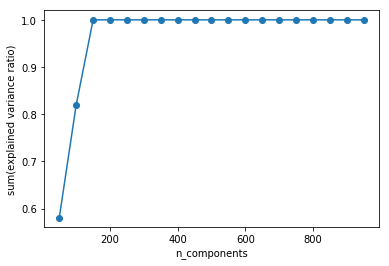

In [14]:
#Identify the number of components for extracting the features
from sklearn.decomposition import PCA

components = range(50, 1000, 50)
evrs = []

for n in components:
    pca_temp = PCA(n_components=n)
    pca_temp.fit(X_trainreshape) # notice that PCA is unsupervised

    # compute sum of ratios (e.g. 0.95, etc)
    evr = np.sum(pca_temp.explained_variance_ratio_)
    evrs.append(evr)
    print(n, ':', evr)
    
fig, ax = plt.subplots()
ax.plot(components, evrs, marker='o')
ax.set(xlabel='n_components', ylabel='sum(explained variance ratio)')
plt.show()

In [23]:
# fit using training set
pca = PCA(n_components=150)
X_trainreshape_150d = pca.fit_transform(X_trainreshape) # compute eigenvectors / eigenvalues
X_testreshape_150d = pca.transform(X_testreshape)

#y_train_labels = Y_train.argmax(axis=1) # one-hot -> labels
#y_test_labels = Y_test.argmax(axis=1) # one-hot -> labels

classifiers_150dPCA = [
    DummyClassifier(random_state=42),
    LogisticRegression(random_state=42),
    SGDClassifier(tol=1e-3, max_iter=1000, random_state=42),
    DecisionTreeClassifier(random_state=42),
    #MLPClassifier(random_state=42), # slow and not so good...
    KNeighborsClassifier()    
]

for clf in classifiers_150dPCA:
    print(type(clf))
    %time clf.fit(X_trainreshape_150d, y_train_labels)
    pred = clf.predict(X_testreshape_150d)
    print(classification_report(y_test_labels, pred))

<class 'sklearn.dummy.DummyClassifier'>
Wall time: 998 µs
             precision    recall  f1-score   support

          0       0.54      0.37      0.44        19
          1       0.00      0.00      0.00        11
          2       0.31      0.45      0.37        20

avg / total       0.33      0.32      0.31        50

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Wall time: 11 ms
             precision    recall  f1-score   support

          0       0.88      0.79      0.83        19
          1       0.60      0.55      0.57        11
          2       0.87      1.00      0.93        20

avg / total       0.82      0.82      0.81        50

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
Wall time: 1.99 ms
             precision    recall  f1-score   support

          0       0.83      0.79      0.81        19
          1       0.60      0.55      0.57        11
          2       0.91      1.00      0.95        20

avg / total       0.81      0.82

## Section 6: Evaluate metrics

Write your code below to evaluate metrics for the trained algorithm(s).

Feel free to plot the algorithm to visualize it, as appropriately.

# Section A (MobileNet)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

X_test_features = featurizer.predict(X_test) # get features

y_pred = classifier.predict(X_test_features) # call classifier

y_test_labels = Y_test.argmax(axis=1) # one-hot -> labels
y_pred_labels = y_pred.argmax(axis=1) # one-hot -> labels
# print(classifier.predict_classes(X_test_features)) # also returns labels

print(classification_report(y_test_labels, y_pred_labels))
print(confusion_matrix(y_test_labels, y_pred_labels))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        19
          1       0.00      0.00      0.00        11
          2       0.42      1.00      0.59        20

avg / total       0.17      0.40      0.24        50

[[ 0  0 19]
 [ 2  0  9]
 [ 0  0 20]]


C:\Users\ChenJ\AppData\Local\Continuum\anaconda3\envs\mldds03\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


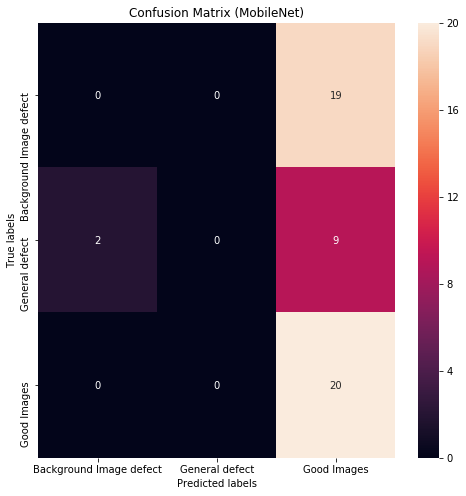

In [26]:
import seaborn as sns
cm = confusion_matrix(y_test_labels, y_pred_labels)

fig, ax = plt.subplots(figsize=(8, 8))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
sns.heatmap(cm, annot=True, ax=ax, fmt='d')
ax.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix (MobileNet)') 
ax.xaxis.set_ticklabels(['Background Image defect', 'General defect', 'Good Images'])
ax.yaxis.set_ticklabels(['Background Image defect', 'General defect', 'Good Images'])
plt.show()

#labels = np.array([[0, 'Background Image defect'], [1, 'General defect'],
#          [2, 'Good Images']])

#fig, ax = plt.subplots()
# annotate cells with ticks
#sns.heatmap(cm, annot=True, ax=ax[0])

#tick_labels = labels[:, 0]

# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
#ax[0].set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix (MobileNet)') 
#ax[0].xaxis.set_ticklabels(tick_labels)
#ax[0].yaxis.set_ticklabels(tick_labels)

plt.show()

# Section B (Other classifiers without PCA)

In [27]:
y_test_labels

array([2, 1, 0, 2, 1, 2, 0, 1, 0, 1, 0, 1, 2, 2, 2, 1, 0, 2, 2, 0, 0, 1,
       2, 0, 1, 2, 2, 1, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 1, 2, 2], dtype=int64)

<class 'sklearn.dummy.DummyClassifier'>
Wall time: 0 ns
             precision    recall  f1-score   support

          0       0.54      0.37      0.44        19
          1       0.00      0.00      0.00        11
          2       0.31      0.45      0.37        20

avg / total       0.33      0.32      0.31        50



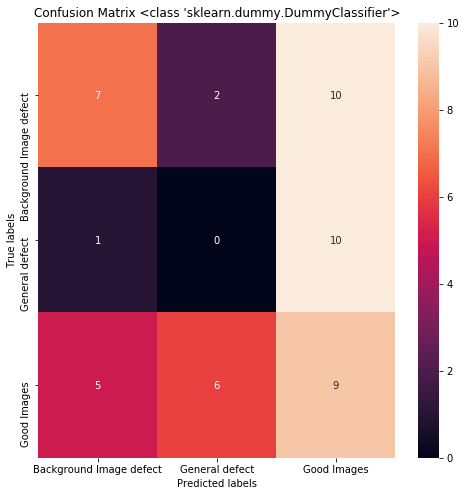

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Wall time: 4.78 s
             precision    recall  f1-score   support

          0       0.86      0.32      0.46        19
          1       0.75      0.27      0.40        11
          2       0.51      1.00      0.68        20

avg / total       0.70      0.58      0.53        50



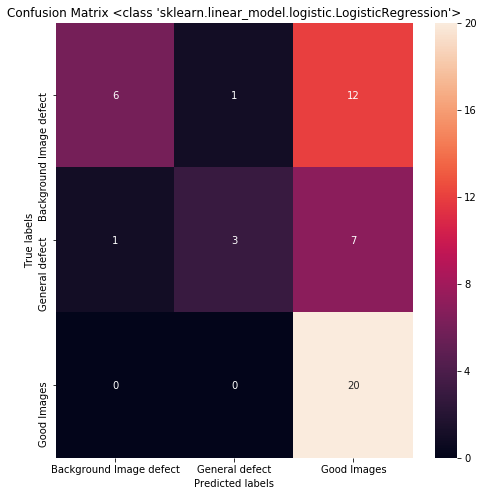

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
Wall time: 437 ms
             precision    recall  f1-score   support

          0       0.80      0.63      0.71        19
          1       1.00      0.18      0.31        11
          2       0.58      0.95      0.72        20

avg / total       0.75      0.66      0.62        50



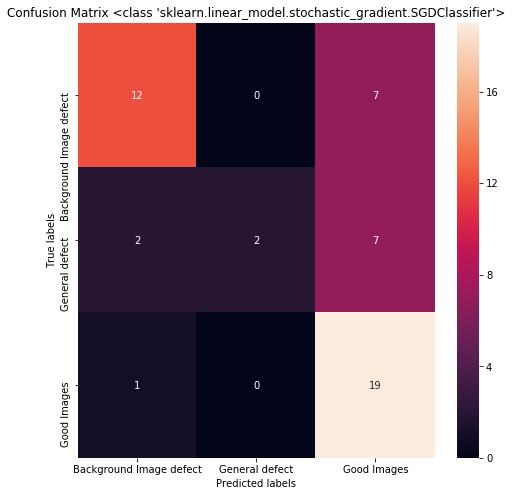

<class 'sklearn.tree.tree.DecisionTreeClassifier'>
Wall time: 2.16 s
             precision    recall  f1-score   support

          0       0.87      0.68      0.76        19
          1       0.47      0.64      0.54        11
          2       0.90      0.90      0.90        20

avg / total       0.79      0.76      0.77        50



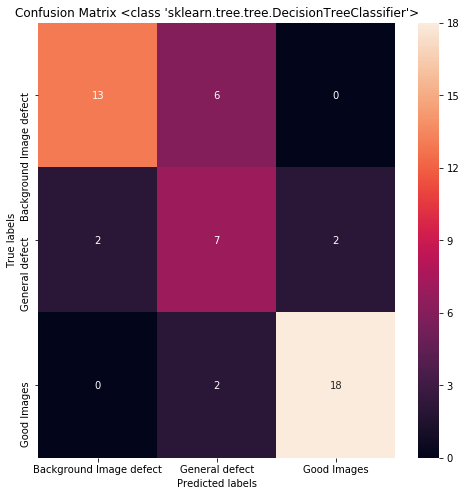

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Wall time: 269 ms
             precision    recall  f1-score   support

          0       0.78      0.74      0.76        19
          1       1.00      0.09      0.17        11
          2       0.65      1.00      0.78        20

avg / total       0.77      0.70      0.64        50



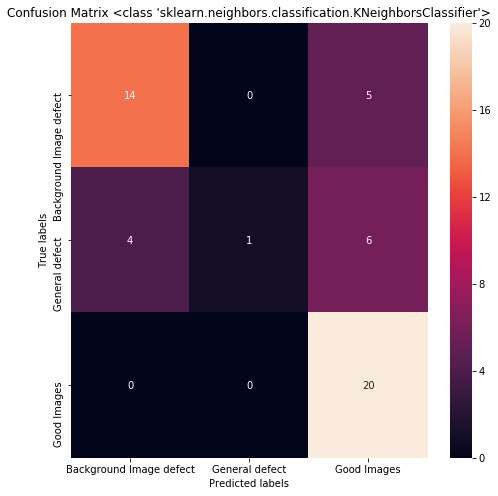

In [33]:
import seaborn as sns
#preds = []

for clf in classifiers:
    print(type(clf))
    %time clf.fit(X_trainreshape, y_train_labels)
    pred = clf.predict(X_testreshape)
    #preds.append(pred)
    
    print(classification_report(y_test_labels, pred))
    cm = confusion_matrix(y_test_labels, pred)

    fig, ax = plt.subplots(figsize=(8, 8))

    # https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
    sns.heatmap(cm, annot=True, ax=ax, fmt='d')
    ax.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix %s' % clf.__class__) 
    ax.xaxis.set_ticklabels(['Background Image defect', 'General defect', 'Good Images'])
    ax.yaxis.set_ticklabels(['Background Image defect', 'General defect', 'Good Images'])
    plt.show()

In [53]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

y_scores = []
n_classes = len(y_train_labels)

classifiers_150dPCA[0].predict()

classifiers_150dPCA_auc = [
    DummyClassifier(random_state=42),
    LogisticRegression(random_state=42),
    SGDClassifier(tol=1e-3, max_iter=1000, random_state=42),
    DecisionTreeClassifier(random_state=42),
    #MLPClassifier(random_state=42), # slow and not so good...
    KNeighborsClassifier()    
]

# binarize labels 

for c in classifiers_150dPCA_auc:
    clf = OneVsRestClassifier(c)
    # fit
    
    # 
    if hasattr(clf, 'decision_function'):
        y_score = clf.decision_function(X_testreshape) # multiclass (n_samples, n_classes)
                                                       # binary (n_samples,)
    else:
        y_score = clf.predict_proba(X_testreshape)[1]
    y_scores.append(y_score)

# plot ROC   
    
for x in range(n_classes):
#    print(type(clf))
#    %time clf.fit(X_trainreshape, y_train_labels)
#    pred = clf.predict(X_testreshape)
    #preds.append(pred)
    if hasattr(classifiers[x], 'decision_function'):
        y_score = classifiers[x].decision_function(X_testreshape)
    else:
        y_score = classifiers[x].predict_proba(X_testreshape)[1]
    y_scores.append(y_score)
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_labels[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test_labels.ravel(), y_scores.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

AttributeError: 'DecisionTreeClassifier' object has no attribute 'decision_function'

In [46]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

ValueError: need at least one array to concatenate

In [ ]:
# Example of plotting the ROC curves to compare classifiers
from sklearn.metrics import roc_curve, auc

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

#
# plot the classifiers
#
for clf in classifiers:
    # some classifiers provide .decision_function(), others provide .predict_proba()
    if hasattr(clf, 'decision_function'):
        y_confidence = clf.decision_function(X_testreshape)
    
        # positive label = class 0
        fpr0, tpr0, _ = roc_curve(y_test_labels, y_confidence, pos_label=0)

        # positive label = class 1
        fpr1, tpr1, _ = roc_curve(y_test_labels, y_confidence, pos_label=1)
        
        # positive label = class 2
        fpr2, tpr2, _ = roc_curve(y_test_labels, y_confidence, pos_label=2)
    else:
        y_confidence = clf.predict_proba(X_testreshape)

        # positive label = class 0
        fpr0, tpr0, _ = roc_curve(y_test_labels, y_confidence[:, 0], pos_label=0)

        # positive label = class 1
        fpr1, tpr1, _ = roc_curve(y_test_labels, y_confidence[:, 1], pos_label=1)
        
        # positive label = class 2
        fpr2, tpr2, _ = roc_curve(y_test_labels, y_confidence[:, 2], pos_label=2)

    ax1.plot(fpr1, tpr1, label='%s (area = %f)' % (clf.__class__, auc(fpr1, tpr1)))
    ax0.plot(fpr0, tpr0, label='%s (area = %f)' % (clf.__class__, auc(fpr0, tpr0)))        
    ax2.plot(fpr2, tpr2, label='%s (area = %f)' % (clf.__class__, auc(fpr2, tpr2)))

# put the plots together
ax0.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC curves (positive label="Background image defect")')
ax0.legend()
ax0.grid()

ax1.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC curves (positive label="General defect")')
ax1.legend()
ax1.grid()

ax2.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC curves (positive label="Good Images")')
ax2.legend()
ax2.grid()

plt.show()

# Section C (Other classifiers with PCA)

<class 'sklearn.dummy.DummyClassifier'>
Wall time: 0 ns
             precision    recall  f1-score   support

          0       0.54      0.37      0.44        19
          1       0.00      0.00      0.00        11
          2       0.31      0.45      0.37        20

avg / total       0.33      0.32      0.31        50



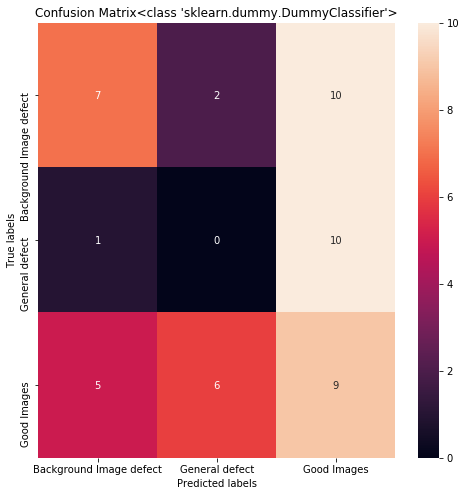

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Wall time: 14 ms
             precision    recall  f1-score   support

          0       0.88      0.79      0.83        19
          1       0.60      0.55      0.57        11
          2       0.87      1.00      0.93        20

avg / total       0.82      0.82      0.81        50



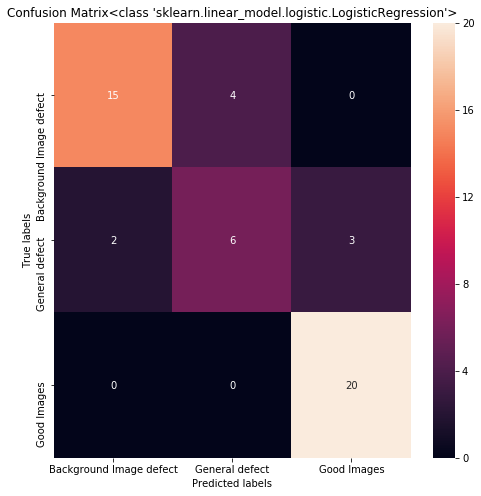

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
Wall time: 3 ms
             precision    recall  f1-score   support

          0       0.83      0.79      0.81        19
          1       0.60      0.55      0.57        11
          2       0.91      1.00      0.95        20

avg / total       0.81      0.82      0.81        50



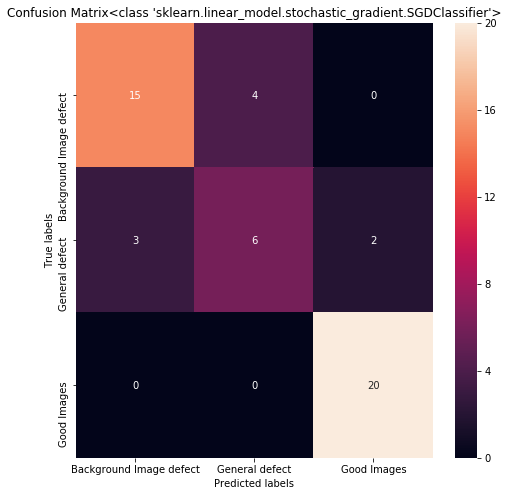

<class 'sklearn.tree.tree.DecisionTreeClassifier'>
Wall time: 14 ms
             precision    recall  f1-score   support

          0       0.92      0.63      0.75        19
          1       0.33      0.36      0.35        11
          2       0.76      0.95      0.84        20

avg / total       0.73      0.70      0.70        50



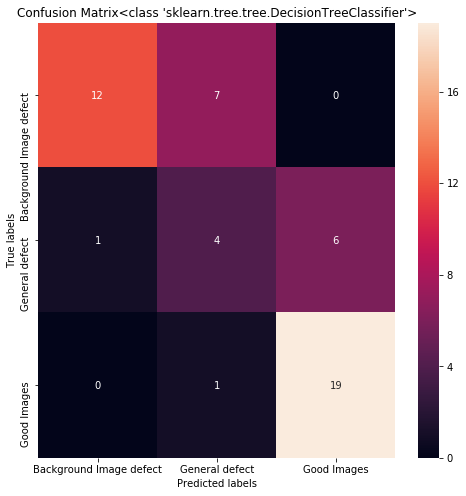

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Wall time: 997 µs
             precision    recall  f1-score   support

          0       0.78      0.74      0.76        19
          1       1.00      0.09      0.17        11
          2       0.65      1.00      0.78        20

avg / total       0.77      0.70      0.64        50



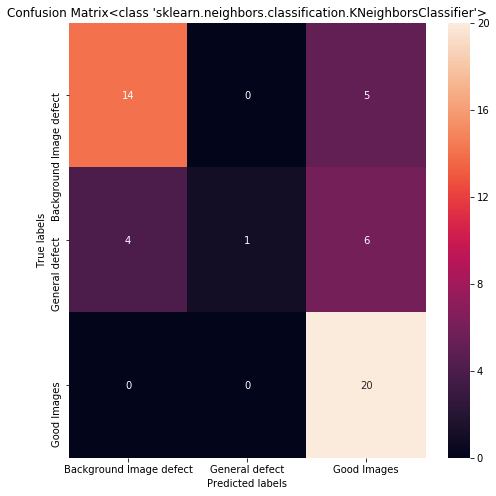

In [55]:
for clf2 in classifiers_150dPCA:
    print(type(clf2))
    %time clf2.fit(X_trainreshape_150d, y_train_labels)
    pred = clf2.predict(X_testreshape_150d)
    print(classification_report(y_test_labels, pred))
    cm = confusion_matrix(y_test_labels, pred)

    fig, ax = plt.subplots(figsize=(8, 8))

    # https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
    sns.heatmap(cm, annot=True, ax=ax, fmt='d')
    ax.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix%s' % clf2.__class__) 
    ax.xaxis.set_ticklabels(['Background Image defect', 'General defect', 'Good Images'])
    ax.yaxis.set_ticklabels(['Background Image defect', 'General defect', 'Good Images'])
    plt.show()

## Section 7: Observations and analysis

Answer the following questions:
1. How did you measure the algorithm? Specify the metrics you used.

2. What is the outcome of the measurement? Explain the interpretation of the metrics.

  - Is there overfitting or underfitting?
  - Is there low accuracy or high error? If so, why do you think this is the case?

3. What improvements do you propose? 

4. What is the most challenging part of this project?

# Outcome
- PCA of 150 features with Logistic regression and SGD is the best

# Improvements
- Get more data for all the different classes

# Challenging
- Separating of the images into the various classes using manual inspections